In [1]:
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.preprocessing import LabelEncoder
from typing import List, Union, Type, Any
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, confusion_matrix, accuracy_score, f1_score, r2_score,  precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
class DecisionTree:
    
    """Класс дерева решений
    
    Параметры:
    self.max_depth (int): Максимальная глубина дерева.
    self.min_samples_split (int): Минимальное количество объектов для разбиения узла.
    self.criterion (str): Критерий разбиения ('gini' для классификации, 'mse' для регрессии).
    self.tree (dict | None): Структура дерева, инициализируется после обучения.
    
    Методы:
    fit(self, X: pd.DataFrame, y: pd.DataFrame): - обучение модели.
    _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int): - Рекурсивное построение дерева 
    _best_split(self, X: pd.DataFrame, y: pd.DataFrame): Поиск наилучшего разбиения 
    _split_score(self, left_y: : pd.DataFrame, right_y: : pd.DataFrame): Оценка качества разбиения (Gini для классификации, MSE для регрессии): 
    _gini(self, y): Расчет критерия Джини.
    _mse(self, y): Расчет среднеквадратичной ошибки 
    _is_pure(self, y): Проверка, содержит ли y только один уникальный класс
    _create_leaf(self, y):  Создание листового узла
    predict(self, X): Метод предсказания(Применение дерева к данным)
    _traverse_tree(self, x, node): метод - выполняет рекурсивный обход дерева решений для предсказания значения на основе входных данных
    """
    
    def __init__(self, max_depth: int =5, min_samples_split: int =2, criterion: str='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion  
        self.tree = None
    
    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray) -> None:
        
        """
        Обучение модели. X - обучающие данные, y - целевые значения.
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        
        self.tree = self._build_tree(X, y, 0)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> dict | float:
        """
        Рекурсивное построение дерева.
        Параметры:
            X - обучающие данные,
            y - целевые значения,
            depth - текущая глубина.
        Возвращает узел дерева (словарь) или лист (число).
        """
    
        if depth >= self.max_depth or len(y) < self.min_samples_split or self._is_pure(y):
            return self._create_leaf(y)
        
        feature, threshold = self._best_split(X, y)
        
        if feature == -1:  # Проверяем, что разбиение найдено
            return self._create_leaf(y)
    
        left_idx = X[:, feature] < threshold
        right_idx = ~left_idx
    
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_idx], y[left_idx], depth + 1),
            'right': self._build_tree(X[right_idx], y[right_idx], depth + 1)
        }


    def _best_split(self, X: np.ndarray, y: np.ndarray) -> tuple[int | None, float | None]:

        """
        Поиск наилучшего разбиения.
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает индекс признака и порог или (None, None), если разбиение невозможно.
        """
        
        best_feature, best_threshold = None, None
        best_score = np.inf  
    
        for feature in range(X.shape[1]):  
            thresholds = np.unique(X[:, feature])  
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = ~left_mask  
    
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue  
    
                score = self._split_score(y[left_mask], y[right_mask])  
    
                if score < best_score:  
                    best_feature, best_threshold, best_score = feature, threshold, score
    
        if best_feature is None or best_threshold is None:  # Защита от ошибки
            return -1, np.nan  # Вместо None вернем фиктивное значение
    
        return best_feature, best_threshold

    def _split_score(self, left_y: np.ndarray, right_y: np.ndarray) -> float:

        """
        Оценка качества разбиения (Gini для классификации, MSE для регрессии).
        Параметры:
            left_y - целевые значения слева,
            right_y - целевые значения справа,
        Возвращает результат оценки.
        """
       
        if self.criterion == 'gini':
            return self._gini(left_y) * len(left_y) + self._gini(right_y) * len(right_y)
        elif self.criterion == 'mse':
            return self._mse(left_y) * len(left_y) + self._mse(right_y) * len(right_y)

    def _gini(self, y: np.ndarray) -> float:

        """
        Расчет критерия Джини.
        Параметры:
            y - целевые значения,
        Возвращает критерий Джини.
        """
        
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def _mse(self, y: np.ndarray) -> float:

        """
        Расчет среднеквадратичной ошибки..
        Параметры:
            y - целевые значения,
        Возвращает MSE.
        """
       
        return np.mean((y - np.mean(y)) ** 2)
    
    def _is_pure(self, y: np.ndarray) -> bool:

        """
        Проверка, содержит ли y только один уникальный класс.
        Параметры:
            y - целевые значения,
        Возвращает да или нет.
        """
        
        return len(np.unique(y)) == 1
    
    def _create_leaf(self, y: np.ndarray) -> float:

        """
        Создание листового узла.
        Параметры:
            y - целевые значения,
        Возвращает среднее значение
        """
       
        if self.criterion == 'mse':
            return np.mean(y)  # Для регрессии - среднее значение
        elif self.criterion == 'gini':
            return np.bincount(y.astype(int)).argmax()  # Для классификации - наиболее частый класс
    
    def predict(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:

        """
        Предсказание классов или значений для входных данных X.
        Параметры:
            X - проверочные данные,
        Возвращает массив предсказаний
        """
        # print(X.shape)
        X = np.atleast_2d(X)

        return np.array([self._traverse_tree(x.flatten(), self.tree) for x in X])

    def _traverse_tree(self, x: np.ndarray, node: dict | float) -> float:

        """
        Выполняет рекурсивный обход дерева решений для предсказания значения.
        Параметры:
            X - проверочные данные,
        Возвращает предсказание модели
        """
        
        if not isinstance(node, dict):  # Если узел — лист, вернуть значение
            return node
        
        # Преобразуем x в numpy-массив и проверяем форму
        x = np.asarray(x).flatten()  # Делаем его одномерным вектором
        
        # print(f"Текущий узел: {node}, размер x: {x.shape}")
        if x.shape[0] <= node['feature']:  # Проверяем, чтобы индекс существовал
            raise IndexError(f"Ошибка: feature index {node['feature']} выходит за границы (размер x: {x.shape[0]})")
        
        if x[node['feature']] < node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])

In [3]:
def fit_tree(tree, X, y):
    """
    Функция для обучения одного дерева (нужна для joblib)
    Параметры:
            tree : Any Базовое дерево решений.
            X - обучающие данные,
            y - целевые значения,
    Возвращает: обученное дерево
    """
    X_sample, y_sample = RandomForest._bootstrap_sample_static(X, y)
    tree.fit(X_sample, y_sample)
    return tree


class RandomForest:
    """Класс случайного леса (RandomForest).
    
    Параметры:
    ----------
    base_tree : Type[Any]             Класс базового дерева решений.
    n_trees : int, default=10         Количество деревьев в лесу.
    max_depth : int, default=5        Максимальная глубина каждого дерева.
    min_samples_split : int, default=2        Минимальное количество объектов в узле перед разделением.
    max_features : default=None        Максимальное количество признаков, используемых при разделении (по умолчанию все).
    random_state : , default=None        Начальное значение для генератора случайных чисел (для воспроизводимости).
    forest_type : str, default='regression'        Тип задачи: 'regression' для регрессии, 'classification' для классификации.
    trees : List[Any]        Список обученных деревьев решений.

    Методы:
    -------
    fit(X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None
        Обучает случайный лес на данных X и y.
    predict(X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray
        Выполняет предсказание на новых данных X.
    _bootstrap_sample_static(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]
        Создаёт бутстрэп-выборку (сэмплирование с возвращением).
    """

    def __init__(
        self,
        base_tree: Type[Any],
        n_trees: int = 10,
        max_depth: int = 5,
        min_samples_split: int = 2,
        max_features: int = None,
        random_state: int = None,
        forest_type: str = "regression"
    ) -> None:
        self.n_trees = n_trees
        self.max_features = max_features
        self.random_state = random_state
        self.forest_type = forest_type
        self.trees: List[Any] = [
            base_tree(max_depth=max_depth, min_samples_split=min_samples_split,
                     criterion="mse" if forest_type == "regression" else "gini")
            for _ in range(self.n_trees)
        ]

    @staticmethod
    def _bootstrap_sample_static(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Создаёт бутстрэп-выборку из X и y.
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает выборку
        """
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None:
        
        """
        Обучает случайный лес(выборку)
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает выборку
        """
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()

        assert isinstance(X, np.ndarray), f"Ошибка: X имеет тип {type(X)}"
        assert isinstance(y, np.ndarray), f"Ошибка: y имеет тип {type(y)}"

        np.random.seed(self.random_state)  # Фиксируем сид для воспроизводимости

        def fit_tree(tree, X, y):
            X_sample, y_sample = self._bootstrap_sample_static(X, y)
            tree.fit(X_sample, y_sample)
            return tree

        self.trees = Parallel(n_jobs=-1)(delayed(fit_tree)(tree, X, y) for tree in self.trees)

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """
        Выполняет предсказание, усредняя результаты деревьев (для регрессии) или голосованием (для классификации).
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает матрицу предсказаний
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        predictions = np.array(Parallel(n_jobs=-1)(delayed(tree.predict)(X) for tree in self.trees))  # (N_trees, N_samples)

        if self.forest_type == "regression":
            return np.mean(predictions, axis=0)
        elif self.forest_type == "classification":
            return np.array([Counter(predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])])
        else:
            raise ValueError("Некорректное значение forest_type. Используйте 'regression' или 'classification'.")

    def get_params(self, deep=True):
        """
        Возвращает параметры модели, как это делает sklearn.
        """
        return {"n_trees": self.n_trees, "max_depth": self.max_depth}

    def set_params(self, **params):
        """
        Устанавливает параметры модели, как это делает sklearn.
        """
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [10]:
def fit_boosting_tree(tree: Any, X: Union[np.ndarray, pd.DataFrame], residuals: Union[np.ndarray, pd.Series]) -> Any:
    """
    Обучает одно дерево на остатках ошибки (нужно для joblib).

    Параметры:
        tree : Any Базовое дерево решений.
        X : Union[np.ndarray, pd.DataFrame]        Обучающие данные.
        residuals : Union[np.ndarray, pd.Series]   Остатки ошибок модели.
    Возвращает:
        tree : Any  Обученное дерево.
    """
    
    if isinstance(residuals, pd.Series):
        residuals = residuals.to_numpy()

    if tree.criterion == 'gini':  # Если это классификация, приводим к int
        residuals = residuals.astype(int)

    tree.fit(X, residuals)
    return tree

class XGBoost:
    """
    Реализация градиентного бустинга деревьев решений (XGBoost).
    
    Параметры:
    base_tree : Type[Any]        Класс базового дерева решений.
    n_trees : int, default=10        Количество деревьев в ансамбле.
    max_depth : int, default=5        Максимальная глубина каждого дерева.
    min_samples_split : int, default=2        Минимальное количество объектов в узле перед разделением.
    learning_rate : float, default=0.1        Скорость обучения (вес каждого нового дерева).
    random_state : int, default=None        Начальное значение для генератора случайных чисел (для воспроизводимости).
    forest_type : str, default='regression'        Тип задачи: 'regression' для регрессии, 'classification' для классификации.
    trees : List[Any]        Список обученных деревьев решений.
    initial_prediction : float        Начальное предсказание (среднее значение целевой переменной для регрессии,
        либо наиболее частый класс для классификации).

    Методы:
    -------
    fit(X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None        Обучает модель на данных X и y.
    predict(X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray        Выполняет предсказание на новых данных X.
    """

    def __init__(
        self,
        base_tree: Type[Any],
        n_trees: int = 10,
        max_depth: int = 5,
        min_samples_split: int = 2,
        learning_rate: float = 0.1,
        random_state: int = None,
        forest_type: str = "regression"
    ) -> None:
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.forest_type = forest_type
        self.trees: List[Any] = []
        self.initial_prediction: float = None
        self.base_tree = base_tree  # Сохраняем базовую модель

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None:
        """
        Обучает деревья последовательно (градиентный бустинг).
    
        Параметры:
            tree : Any Базовое дерево решений.
            X : Union[np.ndarray, pd.DataFrame]        Обучающие данные.
            y: Union[np.ndarray, pd.Series]    Целевые обучющие данные

        """
        
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)  # Приводим X к DataFrame для удобства

        if self.forest_type == "regression":
            self.initial_prediction = np.mean(y)
        else:
            self.initial_prediction = Counter(y).most_common(1)[0][0]

        predictions = np.full_like(y, self.initial_prediction, dtype=np.float64)

        for _ in range(self.n_trees):
            residuals = y - predictions  # Остатки ошибки

            tree = self.base_tree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion="mse" if self.forest_type == "regression" else "gini"
            )

            tree = fit_boosting_tree(tree, X, residuals)  # Обучаем дерево на остатках ошибки
            self.trees.append(tree)  # Добавляем в ансамбль

            predictions += self.learning_rate * tree.predict(X)  # Обновляем предсказания

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        
        """
        Выполняет предсказание, суммируя результаты деревьев.
    
        Параметры:
            tree : Any Базовое дерево решений.
            X : Union[np.ndarray, pd.DataFrame]        Валидирущие данные.
        Возвращает:
            np.ndarray  - матрицу предсказаний
        """
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()  # Приводим X к numpy

        predictions = np.full(X.shape[0], self.initial_prediction, dtype=np.float64)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        if self.forest_type == "classification":
            return np.round(predictions).astype(int)  # Приводим к целым числам для классификации
        return predictions

In [4]:
boston_df = pd.read_csv('content/BostonHousing.csv')

In [5]:
X = boston_df.drop(columns=['medv'])
y = boston_df.medv

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Создаём Random Forest для регрессии
forest = RandomForest(
    base_tree=DecisionTree,  
    n_trees=10, 
    max_depth=5, 
    min_samples_split=2, 
    max_features=5, 
    random_state=42, 
    forest_type='regression'
)

# Обучаем
forest.fit(X_train, y_train)


In [8]:

# Предсказываем
y_pred = forest.predict(X_test.to_numpy())  # Преобразуем DataFrame в numpy

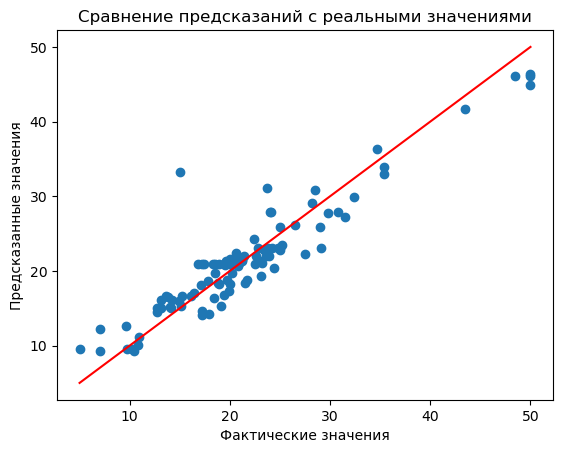

In [9]:
plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Линия идеального предсказания
plt.show()

In [11]:
xgboost_model = XGBoost(
    base_tree=DecisionTree,  # Базовая модель — наше дерево решений
    n_trees=50,              # Количество деревьев
    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева в итоговое предсказание)
    max_depth=5,             # Глубина деревьев
    forest_type='regression' # Режим работы: регрессия 
)
xgboost_model.fit(X_train, y_train)


In [12]:
# Предсказываем
y_pred_xgb = xgboost_model.predict(X_test)

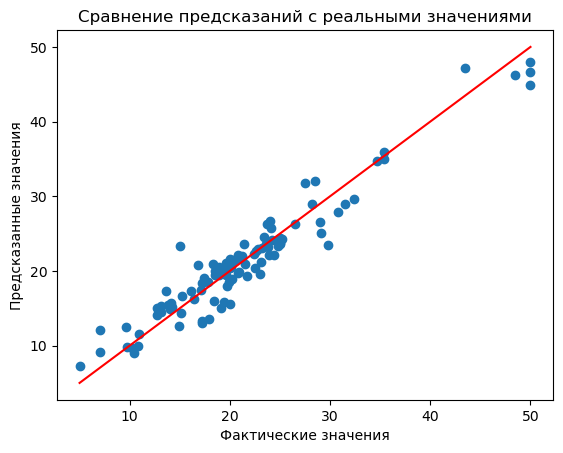

In [13]:
plt.scatter(y_test, y_pred_xgb)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Линия идеального предсказания
plt.show()